In [1]:
#######################################
###
### environment setup
###
#######################################

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, transform, CRS
from shapely.geometry import Polygon, Point
import datetime
from pprint import pprint
import pprint

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# display full
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
import geopandas as gpd

In [4]:
import geoplot as gplt

In [5]:
#######################################
###
### identify source data sets
###
#######################################

In [103]:
files = {
    'via_data': '../resource_files/via_datadict.csv',
    'tracts' : '../resource_files/bexar_county/Bexar_County_Census_Tracts-shp/Bexar_County_Census_Tracts.shp', 
    'block_groups' : '../resource_files/bexar_county/Bexar_County_Census_Block_Groups-shp/Bexar_County_Census_Block_Groups.shp', 
    'blocks' : '../resource_files/bexar_county/Bexar_County_Census_Blocks-shp/Bexar_County_Census_Blocks.shp', 
    'adherence_2020' : '../resource_files/Adherence_2020.csv',
    'bus_otp_2020' : '../resource_files/BusOnTimePerformance_2020.csv',
    'bus_fare_box_2020' : '../fred/bus_fare_fixed.csv',
    'message_logs_2020' : '../resource_files/Logged_Messages.csv',
    'service_miles_2020' : '../resource_files/TotalServiceMiles_2020.csv',
    'stops_addr_2020' : '../resource_files/Stops_LatLong_GeocodeData_2020.csv',
    'stops_201909' : '../resource_files/via_201909/stops.txt', 
    'stops_202004' : '../resource_files/via_202004/stops.csv', 
    'trips_201909' : '../resource_files/via_201909/trips.txt', 
    'trips_202004' : '../resource_files/via_202004/trips.csv', 
    'routes_201909' : '../resource_files/via_201909/routes.txt', 
    'routes_202004' : '../resource_files/via_202004/routes.csv', 
    'stop_times_201909' : '../resource_files/via_201909/stop_times.txt', 
    'stop_times_202004' : '../resource_files/via_202004/stop_times.csv', 
    'transfers_201909' : '../resource_files/via_201909/transfers.txt', 
    'transfers_202004' : '../resource_files/via_202004/transfers.csv', 
    'shapes_201909' : '../resource_files/via_201909/shapes.txt', 
    'shapes_202004' : '../resource_files/via_202004/shapes.csv', 
    'group_stops' : '../resource_files/group_stops-shp'
}

In [7]:
via_datadict = pd.read_csv(files['via_data'])
print('*** via_datadict ***\n')
print(via_datadict.info())

via_rename = via_datadict.set_index('via_column')['gotb_column']
print('\n\n*** via_rename ***\n')
print(via_rename.head())

via_datatype = via_datadict.set_index('via_column')['datatype']
print('\n\n*** via_datatype ***\n')
print(via_datatype.head())

gotb_datatype = via_datadict.set_index('gotb_column')['datatype']
print('\n\n*** gotb_datatype ***\n')
print(gotb_datatype.head())

*** via_datadict ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   via_column   54 non-null     object 
 1   gotb_column  54 non-null     object 
 2   datatype     54 non-null     object 
 3   description  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 1.8+ KB
None


*** via_rename ***

via_column
ServiceDate           service_date
Routes                       route
Block                  route_block
RouteDirectionName       route_dir
StopNumber                 stop_id
Name: gotb_column, dtype: object


*** via_datatype ***

via_column
ServiceDate           datetime64
Routes                    string
Block                     string
RouteDirectionName        string
StopNumber                string
Name: datatype, dtype: object


*** gotb_datatype ***

gotb_column
service_date    datetime64
route               string
route

In [8]:
#######################################
###
### set up census data
###
#######################################

In [9]:
gdf_tracts = gpd.read_file(files['tracts']).set_index('OBJECTID')
gdf_tracts.index.name = 'TRACTID'
gdf_tracts['density']=gdf_tracts.SUM_POPULA / gdf_tracts.ShapeSTAre.min()
gdf_tracts = gdf_tracts.to_crs('epsg:4326')
gdf_tracts = gdf_tracts.astype({'TRACT':'string'})
print(gdf_tracts.info())
gdf_tracts.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 366 entries, 1 to 366
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   TRACT       366 non-null    string  
 1   SUM_POPULA  366 non-null    int64   
 2   ShapeSTAre  366 non-null    float64 
 3   ShapeSTLen  366 non-null    float64 
 4   geometry    366 non-null    geometry
 5   density     366 non-null    float64 
dtypes: float64(3), geometry(1), int64(1), string(1)
memory usage: 20.0 KB
None


TRACT  SUM_POPULA    ShapeSTAre    ShapeSTLen  \
TRACTID                                                        
1        48029110100        3379  3.816858e+07  26074.749275   
2        48029110300        2542  1.667905e+07  22363.990201   
3        48029110500        2238  1.366653e+07  16048.493069   
4        48029110600        7553  2.117379e+07  20426.412628   
5        48029110700        1398  1.058371e+07  16998.776148   

                                                  geometry   density  
TRACTID                                                               
1        POLYGON ((-98.48695 29.43502, -98.48626 29.434...  0.000433  
2        POLYGON ((-98.47326 29.41461, -98.47326 29.413...  0.000325  
3        POLYGON ((-98.50799 29.42314, -98.50812 29.422...  0.000287  
4        POLYGON ((-98.50111 29.42735, -98.50121 29.426...  0.000967  
5        POLYGON ((-98.50401 29.44202, -98.50386 29.441...  0.000179

In [10]:
gdf_groups = gpd.read_file(files['block_groups']).set_index('OBJECTID')
gdf_groups.index.name = 'GROUPID'
gdf_groups['density']=gdf_groups.SUM_POPULA / gdf_groups.ShapeSTAre
gdf_groups = gdf_groups.to_crs('epsg:4326')
gdf_groups = gdf_groups.astype({'BLOCKGROUP':'string'})
gdf_groups = gdf_groups.drop(columns=['Shape_STAr','Shape_STLe'])
print(gdf_groups.info())
gdf_groups.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1084 entries, 1 to 1084
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BLOCKGROUP  1084 non-null   string  
 1   SUM_POPULA  1084 non-null   int64   
 2   ShapeSTAre  1084 non-null   float64 
 3   ShapeSTLen  1084 non-null   float64 
 4   geometry    1084 non-null   geometry
 5   density     1084 non-null   float64 
dtypes: float64(3), geometry(1), int64(1), string(1)
memory usage: 59.3 KB
None


BLOCKGROUP  SUM_POPULA    ShapeSTAre    ShapeSTLen  \
GROUPID                                                         
1        480291101001         955  1.951706e+07  23279.128568   
2        480291101002         694  7.319464e+06  14609.297870   
3        480291101003        1730  1.133205e+07  14546.232289   
4        480291103001        1041  4.292228e+06   9662.074836   
5        480291103002         797  4.074139e+06  10523.204970   

                                                  geometry   density  
GROUPID                                                               
1        POLYGON ((-98.48695 29.43502, -98.48626 29.434...  0.000049  
2        POLYGON ((-98.48824 29.41933, -98.48826 29.418...  0.000095  
3        POLYGON ((-98.49432 29.43370, -98.49426 29.433...  0.000153  
4        POLYGON ((-98.47984 29.40970, -98.47983 29.409...  0.000243  
5        POLYGON ((-98.47989 29.40860, -98.47992 29.408...  0.000196

In [11]:
gdf_blocks_cols = [
    'BLOCK', 'BLOCKGROUP', 'TRACT', 'ID', 'COLORING', 'MCD', 
    'PLACE', 'VTD', 'CONGRESS', 'LOWERSLD', 'UPPERSLD', 'UNIFSCHOOL',
    'POPULATION', 'HISPANIC_O', 'NH_WHT', 'NH_BLK', 'NH_ASN', 'NH_OTH',
    'gecovector', 'ShapeSTAre', 'ShapeSTLen', 'geometry'
]

In [12]:
gdf_blocks = gpd.read_file(files['blocks']).set_index('OBJECTID')
gdf_blocks.index.name = 'BLOCKOBJ'
gdf_blocks['NH_OTH'] = (
    gdf_blocks.POPULATION 
    - gdf_blocks.HISPANIC_O 
    - gdf_blocks.NH_WHT 
    - gdf_blocks.NH_BLK 
    - gdf_blocks.NH_ASN
)
# gdf_blocks['density']=gdf_blocks.POPULATION / gdf_blocks.ShapeSTAre
gdf_blocks = gdf_blocks[gdf_blocks_cols]
gdf_blocks = gdf_blocks.to_crs('epsg:4326')
gdf_blocks = gdf_blocks.astype({
    'BLOCK': 'string',
    'BLOCKGROUP': 'string',
    'TRACT': 'string',
    'MCD': 'string',
    'PLACE': 'string',
    'VTD': 'string',
    'CONGRESS': 'string',
    'LOWERSLD': 'string',
    'UPPERSLD': 'string',
    'UNIFSCHOOL': 'string',
})
print(gdf_blocks.info())
gdf_blocks.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26452 entries, 1 to 26452
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BLOCK       26452 non-null  string  
 1   BLOCKGROUP  26452 non-null  string  
 2   TRACT       26452 non-null  string  
 3   ID          26452 non-null  int64   
 4   COLORING    26452 non-null  int64   
 5   MCD         26452 non-null  string  
 6   PLACE       22406 non-null  string  
 7   VTD         26452 non-null  string  
 8   CONGRESS    26452 non-null  string  
 9   LOWERSLD    26452 non-null  string  
 10  UPPERSLD    26452 non-null  string  
 11  UNIFSCHOOL  26452 non-null  string  
 12  POPULATION  26452 non-null  int64   
 13  HISPANIC_O  26452 non-null  int64   
 14  NH_WHT      26452 non-null  int64   
 15  NH_BLK      26452 non-null  int64   
 16  NH_ASN      26452 non-null  int64   
 17  NH_OTH      26452 non-null  int64   
 18  gecovector  26452 non-null  float64 
 

BLOCK    BLOCKGROUP        TRACT       ID  COLORING  \
BLOCKOBJ                                                                  
1         480291919003005  480291919003  48029191900  1400310         4   
2         480291411011002  480291411011  48029141101  1400328         3   
3         480291411011006  480291411011  48029141101  1400348         3   
4         480291410002007  480291410002  48029141000  1400365         1   
5         480291410002006  480291410002  48029141000  1400383         3   

                 MCD    PLACE        VTD CONGRESS LOWERSLD UPPERSLD  \
BLOCKOBJ                                                              
1         4802993407  4865000  480294004     4821    48120    48019   
2         4802993407  4865000  480291074     4823    48119    48019   
3         4802993407  4865000  480291074     4823    48119    48019   
4         4802993407  4865000  480291074     4823    48119    48019   
5         4802993407  4865000  480291074     4823    48119    48019   

         UNIFSCHOOL  POPULATION  HISPANIC_O  NH_WHT  NH_BLK  NH_ASN  NH_OTH  \
BLOCKOBJ                                                                      
1           4838730          13          11       0       0       0       2   
2           4838730           0           0       0       0       0       0   
3           4838730         102          82      16       2       0       2   
4           4838730         162         149      13       0       0       0   
5           4838730         133         124       5       4       0       0   

          gecovector     ShapeSTAre   ShapeSTLen  \
BLOCKOBJ                                           
1           0.001038   28896.121094  1063.271402   
2           0.018304  509512.736328  8615.618889   
3           0.012803  356394.378906  2836.366689   
4           0.012892  358877.382812  2852.304380   
5           0.016129  448943.710938  2994.127235   

                                                   geometry  
BLOCKOBJ                                                     
1         POLYGON ((-98.46781 29.42506, -98.46783 29.424...  
2         POLYGON ((-98.46881 29.36511, -98.46815 29.364...  
3         POLYGON ((-98.46323 29.36640, -98.46324 29.365...  
4         POLYGON ((-98.46667 29.36662, -98.46668 29.367...  
5         POLYGON ((-98.46668 29.36753, -98.46667 29.368...

In [13]:
gdf_counties = gdf_tracts[['TRACT','geometry']].copy()
gdf_counties['COUNTY'] = gdf_counties['TRACT'].str[:5]
gdf_counties.drop(columns='TRACT', inplace=True)
gdf_counties = gdf_counties.dissolve(by='COUNTY').reset_index()
gdf_counties.index.name = 'COUNTYID'
gdf_counties = gdf_counties.astype({'COUNTY':"string"})
gdf_counties.head()

COUNTY                                           geometry
COUNTYID                                                          
0         48029  POLYGON ((-98.32720 29.20987, -98.32725 29.209...

In [14]:
# For simplification, using distance per degree latitude to determine buffer amount. 
# This is slightly inaccurate due to the curvature of the earth. Buffer distances is
# set at 800 meters, which is roughly a half mile.

meters_per_degree = 111111
buffer_in_meters = 750
buffer_in_degrees = buffer_in_meters / meters_per_degree
buffer_in_degrees

0.00675000675000675

In [15]:
#######################################
###
### set up via datathon data
###
#######################################

In [16]:
#######################################
###
### via datathon 2020
###
### adherence
###
#######################################

In [17]:
def retype_dataframe(df, type_dict):
    retype_dict = {k:v for (k,v) in type_dict.items() if k in df.columns}
    # print(retype_dict)
    string_cols = (k for (k,v) in retype_dict.items() if v == 'string')
    # print(string_cols)
    for col in string_cols:
        df[col] = df[col].apply(str)
    df = df.astype(retype_dict).copy()

    return df

In [18]:
def wrangle_adherence(source_file):

    adherence_stops_cols = ['stop_id','stop_name','deg_lat','deg_lon']
    adherence_stops_drops = adherence_stops_cols.copy()
    adherence_stops_drops.remove('stop_id')
    # print(adherence_stops_drops)
    
    df_adh = pd.read_csv(source_file).rename(columns=via_rename)
    df_adh.route_dir = df_adh.route_dir.str.slice(0,1)
    df_adh.vehicle_id = df_adh.vehicle_id.apply(str)
    df_adh.vehicle_id = df_adh.vehicle_id.apply(lambda x: x.replace('.0',''))
    # print('Check F1: df_adh')
    # print(df_adh.info())
    
    gdf_stops = df_adh[adherence_stops_cols]
    # print('\nCheck F2: df_stops')
    # print(gdf_stops.info())
    
    df_adh = df_adh.drop(columns=adherence_stops_drops)
    df_adh = retype_dataframe(df_adh, gotb_datatype)
    # print('\nCheck F3: df_adh')
    # print(df_adh.info())

    adherence_stops_rename = {
        'deg_lat' : 'stop_lat', 
        'deg_lon' : 'stop_lon',
    }
    
    gdf_stops['stops'] = 1
    gdf_stops.deg_lat.fillna(0, inplace=True)
    gdf_stops.deg_lon.fillna(0, inplace=True)
    gdf_stops.deg_lat = gdf_stops.deg_lat * 10 ** -7
    gdf_stops.deg_lon = gdf_stops.deg_lon * 10 ** -7
    gdf_stops = gdf_stops.groupby(adherence_stops_cols).agg({'stops':['sum']}).reset_index()
    gdf_stops.columns = [col[0] for col in gdf_stops.columns]
    # print(new_cols)
    gdf_stops.rename(columns=adherence_stops_rename, inplace=True)
    gdf_stops['stop_code'] = gdf_stops.stop_id
    gdf_stops.set_index('stop_code', inplace=True)
    gdf_stops = retype_dataframe(gdf_stops, gotb_datatype)
    gdf_stops = gpd.GeoDataFrame(
        gdf_stops,
        geometry = gpd.points_from_xy(gdf_stops.stop_lon, gdf_stops.stop_lat),
        crs={'epsg:4326'}
    )
    # print('\nCheck F4: df_stops')
    # print(gdf_stops.info())
    return df_adh, gdf_stops

In [19]:
df_adherence, gdf_stops_adh = wrangle_adherence(files['adherence_2020'])
# print(adh.type())
# df_adherence = adh[0]
# gdf_stops_adh = adh[1]
print('\ndf_adherence')
print(df_adherence.info())
print('\ngdf_stops_adh')
print(gdf_stops_adh.info())


df_adherence
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358328 entries, 0 to 358327
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   service_date    358328 non-null  datetime64[ns]
 1   route           358328 non-null  string        
 2   route_block     358328 non-null  string        
 3   route_dir       358328 non-null  string        
 4   stop_id         358328 non-null  string        
 5   sched_time_s    358328 non-null  float64       
 6   sched_time_hms  358328 non-null  datetime64[ns]
 7   arr_time_s      329729 non-null  float64       
 8   arr_time_hms    329729 non-null  datetime64[ns]
 9   dep_time_s      329729 non-null  float64       
 10  dep_time_hms    329729 non-null  datetime64[ns]
 11  odometer        329684 non-null  float64       
 12  vehicle_id      358328 non-null  string        
dtypes: datetime64[ns](4), float64(4), string(5)
memory usage: 35.5 MB
None

gdf

In [20]:
df_adherence.columns

Index(['service_date', 'route', 'route_block', 'route_dir', 'stop_id',
       'sched_time_s', 'sched_time_hms', 'arr_time_s', 'arr_time_hms',
       'dep_time_s', 'dep_time_hms', 'odometer', 'vehicle_id'],
      dtype='object')

In [21]:
adh_routes_group_cols = ['service_date','route_block','sched_time_s','route_dir','vehicle_id','route','stop_id']
adh_routes_data_cols = ['arr_time_s', 'dep_time_s', 'odometer']
adh_routes = df_adherence[adh_routes_group_cols + adh_routes_data_cols]
adh_routes['arr_odometer'] = adh_routes.odometer
adh_routes['dep_odometer'] = adh_routes.odometer
adh_routes['recs'] = 1
adh_routes = adh_routes.groupby(adh_routes_group_cols).agg({'recs':['count'], 'arr_time_s':['min'],'dep_time_s':['max'],'arr_odometer':['min'],'dep_odometer':['max']}).reset_index()
adh_routes.columns = [col[0] for col in adh_routes.columns]
adh_routes = retype_dataframe(adh_routes, gotb_datatype)
adh_routes['sched_time_hms'] = adh_routes.service_date + pd.to_timedelta(adh_routes.sched_time_s,'sec')
adh_routes['arr_time_hms'] = adh_routes.service_date + pd.to_timedelta(adh_routes.arr_time_s,'sec')
adh_routes['dep_time_hms'] = adh_routes.service_date + pd.to_timedelta(adh_routes.dep_time_s,'sec')
adh_routes['time_stopped'] = adh_routes.dep_time_s - adh_routes.arr_time_s
adh_routes['time_missed'] = adh_routes.dep_time_s - adh_routes.sched_time_s
adh_routes.drop(columns=['sched_time_s', 'arr_time_s', 'dep_time_s'], inplace=True)
adh_routes_sort_cols = ['service_date','route_block','sched_time_hms','vehicle_id','arr_time_hms','arr_odometer','route_dir']
adh_routes = adh_routes.sort_values(by=adh_routes_sort_cols).reset_index().drop(columns='index')

print(adh_routes.info())
adh_routes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357465 entries, 0 to 357464
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   service_date    357465 non-null  datetime64[ns]
 1   route_block     357465 non-null  string        
 2   route_dir       357465 non-null  string        
 3   vehicle_id      357465 non-null  string        
 4   route           357465 non-null  string        
 5   stop_id         357465 non-null  string        
 6   recs            357465 non-null  int64         
 7   arr_odometer    328888 non-null  float64       
 8   dep_odometer    328888 non-null  float64       
 9   sched_time_hms  357465 non-null  datetime64[ns]
 10  arr_time_hms    328933 non-null  datetime64[ns]
 11  dep_time_hms    328933 non-null  datetime64[ns]
 12  time_stopped    328933 non-null  float64       
 13  time_missed     328933 non-null  float64       
dtypes: datetime64[ns](4), float64(4), in

service_date route_block route_dir vehicle_id route stop_id  recs  \
0   2019-09-11     002-001         N        533    34    GARA     1   
1   2019-09-11     002-001         N        533    34   99166     1   
2   2019-09-11     002-001         N        533    34   82589     1   
3   2019-09-11     002-001         N        533    34   11726     1   
4   2019-09-11     002-001         N        533    34   99396     1   

   arr_odometer  dep_odometer      sched_time_hms        arr_time_hms  \
0          0.15          0.15 2019-09-11 00:00:00 2019-09-11 03:40:13   
1           NaN           NaN 2019-09-11 04:09:00                 NaT   
2           NaN           NaN 2019-09-11 04:19:00                 NaT   
3         10.85         10.85 2019-09-11 04:27:00 2019-09-11 04:28:01   
4         11.28         11.28 2019-09-11 04:30:00 2019-09-11 04:31:21   

         dep_time_hms  time_stopped  time_missed  
0 2019-09-11 03:48:21         488.0      13701.0  
1                 NaT           NaN          NaN  
2                 NaT           NaN          NaN  
3 2019-09-11 04:28:14          13.0         74.0  
4 2019-09-11 04:31:21           0.0         81.0

In [22]:
def generate_run_ids(df):
    #setup
    block_run = 0
    previous = ()
    #for loop - condition then yield
    for row in df.index:
        # cur_df = df.loc[row]
        current=(df.service_date[row],df.vehicle_id[row],df.route[row],df.route_block[row],df.route_dir[row])
        # print(run_stop)
        if previous != current:
            block_run += 1
            run_stop = 1
        yield row, block_run, run_stop
        run_stop +=1
        previous=current

# adh_routes_group_cols = ['service_date','vehicle_id','route','sched_time_s','route_block','route_dir','stop_id']
adh_routes_block_cols = adh_routes_group_cols.copy()
# print(adh_routes_block_cols)
adh_routes_block_cols.remove('sched_time_s')
print(len(adh_routes))
gen_df = pd.DataFrame(generate_run_ids(adh_routes[adh_routes_block_cols]), columns=['idx', 'block_run', 'run_stop']).set_index('idx')
print()
print(gen_df.head())
print(gen_df.tail())


357465

     block_run  run_stop
idx                     
0            1         1
1            1         2
2            1         3
3            1         4
4            1         5
        block_run  run_stop
idx                        
357460      75019         4
357461      75020         1
357462      75020         2
357463      75020         3
357464      75020         4


In [23]:
adh_routes = adh_routes.join(gen_df, how='left')
adh_routes.tail(20)

57407          0.12          0.12 2019-09-20 14:20:00 2019-09-20 14:19:12   
357408          7.48          7.48 2019-09-20 14:35:00 2019-09-20 14:33:35   
357409         10.34         10.34 2019-09-20 14:46:00 2019-09-20 14:47:19   
357410         17.90         17.90 2019-09-20 14:55:00 2019-09-20 15:09:13   
357411         17.98         17.98 2019-09-20 14:55:00 2019-09-20 15:09:13   
357412         21.93         21.93 2019-09-20 15:06:00 2019-09-20 15:21:08   
357413         24.55         24.55 2019-09-20 15:17:00 2019-09-20 15:32:36   
357414         25.97         25.97 2019-09-20 15:20:00 2019-09-20 15:38:19   
357415         27.41         27.41 2019-09-20 15:35:00 2019-09-20 15:45:15   
357416         27.49         27.49 2019-09-20 15:40:00 2019-09-20 15:45:15   
357417         30.28         30.28 2019-09-20 15:51:00 2019-09-20 15:58:24   
357418         33.35         33.35 2019-09-20 16:00:00 2019-09-20 16:06:30   
357419         33.43         33.43 2019-09-20 16:00:00 2019-09-20 16:06:30   
357420         37.38         37.38 2019-09-20 16:11:00 2019-09-20 16:17:29   
357421         40.02         40.02 2019-09-20 16:22:00 2019-09-20 16:27:58   
357422         41.43         41.43 2019-09-20 16:25:00 2019-09-20 16:35:54   
357423         42.87         42.87 2019-09-20 16:40:00 2019-09-20 16:44:28   
357424         42.95         42.95 2019-09-20 16:45:00 2019-09-20 16:44:28   
357425         45.75         45.75 2019-09-20 16:56:00 2019-09-20 16:59:25   
357426         48.83         48.83 2019-09-20 17:05:00 2019-09-20 17:08:27   
357427         48.92         48.92 2019-09-20 17:05:00 2019-09-20 17:08:27   
357428         52.87         52.87 2019-09-20 17:16:00 2019-09-20 17:19:33   
357429         55.50         55.50 2019-09-20 17:27:00 2019-09-20 17:28:11   
357430         56.92         56.92 2019-09-20 17:30:00 2019-09-20 17:35:35   
357431         58.36         58.36 2019-09-20 17:45:00 2019-09-20 17:44:46   
357432         58.43         58.43 2019-09-20 17:50:00 2019-09-20 17:44:46   
357433         61.25         61.25 2019-09-20 18:01:00 2019-09-20 18:01:23   
357434         64.32         64.32 2019-09-20 18:10:00 2019-09-20 18:09:31   
357435         64.40         64.40 2019-09-20 18:10:00 2019-09-20 18:09:31   
357436         68.35         68.35 2019-09-20 18:20:00 2019-09-20 18:21:18   
357437         70.99         70.99 2019-09-20 18:30:00 2019-09-20 18:30:42   
357438         72.41         72.41 2019-09-20 18:33:00 2019-09-20 18:38:43   
357439         73.85         73.85 2019-09-20 18:46:00 2019-09-20 18:43:56   
357440         73.92         73.92 2019-09-20 18:50:00 2019-09-20 18:43:56   
357441         76.73         76.73 2019-09-20 19:00:00 2019-09-20 19:01:36   
357442         79.81         79.81 2019-09-20 19:09:00 2019-09-20 19:09:55   
357443         79.88         79.88 2019-09-20 19:09:00 2019-09-20 19:09:55   
357444         83.84         83.84 2019-09-20 19:19:00 2019-09-20 19:19:53   
357445         86.48         86.48 2019-09-20 19:29:00 2019-09-20 19:29:20   
357446         87.89         87.89 2019-09-20 19:32:00 2019-09-20 19:34:15   
357447         89.34         89.34 2019-09-20 19:45:00 2019-09-20 19:41:51   
357448         89.42         89.42 2019-09-20 19:50:00 2019-09-20 19:41:51   
357449         92.23         92.23 2019-09-20 20:00:00 2019-09-20 19:59:49   
357450         95.30         95.30 2019-09-20 20:09:00 2019-09-20 20:08:59   
357451         95.37         95.37 2019-09-20 20:09:00 2019-09-20 20:08:59   
357452         99.33         99.33 2019-09-20 20:19:00 2019-09-20 20:19:49   
357453        101.99        101.99 2019-09-20 20:28:00 2019-09-20 20:28:50   
357454        103.38        103.38 2019-09-20 20:31:00 2019-09-20 20:34:15   
357455        104.91        104.91 2019-09-20 20:43:00 2019-09-20 20:42:05   
357456        112.29        112.29 2019-09-20 20:58:00 2019-09-20 20:53:10   
357457          0.17          0.17 2019-09-20 03:40:00 2019-09-20 03:34:44   
357458          9.79   

In [24]:
adh_routes.recs.value_counts()

1    356606
2       857
4         2
Name: recs, dtype: int64

In [25]:
df_adherence.route_dir.value_counts()

S    116631
N    116201
E     62920
W     62576
Name: route_dir, dtype: Int64

In [26]:
df_adherence.vehicle_id.value_counts().head()

nan    1744
525    1374
529    1290
533    1274
585    1273
Name: vehicle_id, dtype: Int64

In [27]:
check_mult = adh_routes[adh_routes.recs>2].iloc[0]
check_mult

service_date      2019-09-12 00:00:00
route_block                   002-008
route_dir                           S
vehicle_id                        500
route                               2
stop_id                         10059
recs                                4
arr_odometer                     57.7
dep_odometer                    57.74
sched_time_hms    2019-09-12 15:59:00
arr_time_hms      2019-09-12 15:56:10
dep_time_hms      2019-09-12 15:59:15
time_stopped                      185
time_missed                        15
block_run                        8256
run_stop                            2
Name: 38955, dtype: object

In [28]:
check_mult.route_dir

'S'

In [29]:
df_adherence[
    (df_adherence.route == check_mult.route) & 
    (df_adherence.vehicle_id == check_mult.vehicle_id) & 
    (df_adherence.stop_id == check_mult.stop_id) & 
    (df_adherence.route_dir == check_mult.route_dir) 
]

service_date route route_block route_dir stop_id  sched_time_s  \
39052    2019-09-12     2     002-008         S   10059       57540.0   
39053    2019-09-12     2     002-008         S   10059       57540.0   
39054    2019-09-12     2     002-008         S   10059       57540.0   
39055    2019-09-12     2     002-008         S   10059       57540.0   
39118    2019-09-12     2     002-008         S   10059       73200.0   
39119    2019-09-12     2     002-008         S   10059       73200.0   
39120    2019-09-12     2     002-008         S   10059       73200.0   
39121    2019-09-12     2     002-008         S   10059       73200.0   
76915    2019-09-13     2     002-004         S   10059       18600.0   
76941    2019-09-13     2     002-004         S   10059       31260.0   
76942    2019-09-13     2     002-004         S   10059       31260.0   
76968    2019-09-13     2     002-004         S   10059       45360.0   
76969    2019-09-13     2     002-004         S   10059       45360.0   
76995    2019-09-13     2     002-004         S   10059       59340.0   
76996    2019-09-13     2     002-004         S   10059       59340.0   
282234   2019-09-19     2     002-004         S   10059       18600.0   
282260   2019-09-19     2     002-004         S   10059       31260.0   
282261   2019-09-19     2     002-004         S   10059       31260.0   
282287   2019-09-19     2     002-004         S   10059       45360.0   
282288   2019-09-19     2     002-004         S   10059       45360.0   
282314   2019-09-19     2     002-004         S   10059       59340.0   
282315   2019-09-19     2     002-004         S   10059       59340.0   

            sched_time_hms  arr_time_s        arr_time_hms  dep_time_s  \
39052  2020-07-16 15:59:00     57370.0 2020-07-16 15:56:10     57370.0   
39053  2020-07-16 15:59:00     57370.0 2020-07-16 15:56:10     57555.0   
39054  2020-07-16 15:59:00     57370.0 2020-07-16 15:56:10     57370.0   
39055  2020-07-16 15:59:00     57370.0 2020-07-16 15:56:10     57555.0   
39118  2020-07-16 20:20:00     73076.0 2020-07-16 20:17:56     73076.0   
39119  2020-07-16 20:20:00     73076.0 2020-07-16 20:17:56     73223.0   
39120  2020-07-16 20:20:00     73076.0 2020-07-16 20:17:56     73076.0   
39121  2020-07-16 20:20:00     73076.0 2020-07-16 20:17:56     73223.0   
76915  2020-07-16 05:10:00     18211.0 2020-07-16 05:03:31     18227.0   
76941  2020-07-16 08:41:00     31043.0 2020-07-16 08:37:23     31043.0   
76942  2020-07-16 08:41:00     31043.0 2020-07-16 08:37:23     31229.0   
76968  2020-07-16 12:36:00     45091.0 2020-07-16 12:31:31     45091.0   
76969  2020-07-16 12:36:00     45091.0 2020-07-16 12:31:31     45427.0   
76995  2020-07-16 16:29:00     59461.0 2020-07-16 16:31:01     59461.0   
76996  2020-07-16 16:29:00     59461.0 2020-07-16 16:31:01     59579.0   
282234 2020-07-16 05:10:00     18103.0 2020-07-16 05:01:43     18118.0   
282260 2020-07-16 08:41:00     31037.0 2020-07-16 08:37:17     31037.0   
282261 2020-07-16 08:41:00     31037.0 2020-07-16 08:37:17     31315.0   
282287 2020-07-16 12:36:00     45210.0 2020-07-16 12:33:30     45210.0   
282288 2020-07-16 12:36:00     45210.0 2020-07-16 12:33:30     45430.0   
282314 2020-07-16 16:29:00     59187.0 2020-07-16 16:26:27     59187.0   
282315 2020-07-16 16:29:00     59187.0 2020-07-16 16:26:27     59347.0   

              dep_time_hms  odometer vehicle_id  
39052  2020-07-16 15:56:10     57.70        500  
39053  2020-07-16 15:59:15     57.74        500  
39054  2020-07-16 15:56:10     57.70        500  
39055  2020-07-16 15:59:15     57.70        500  
39118  2020-07-16 20:17:56    113.81        500  
39119  2020-07-16 20:20:23    113.88        500  
39120  2020-07-16 20:17:56    113.78        500  
39121  2020-07-16 20:20:23    113.84        500  
76915  2020-07-16 05:03:47      6.29        500  
76941  2020-07-16 08:37:23     48.18        500  
76942  2020-07-16 08:40:29     48.26        500  
76968  2020-07-16 12:31:

In [30]:
df_adherence[
    df_adherence.arr_time_s.isna() != df_adherence.odometer.isna()
].head()

service_date route route_block route_dir stop_id  sched_time_s  \
11789   2019-09-11    26     020-007         W   11269       24600.0   
12692   2019-09-11    26     020-016         W   11269       56820.0   
12876   2019-09-11    26     020-018         W   11269       53040.0   
50399   2019-09-12    26     020-009         W   11269       59040.0   
50425   2019-09-12    26     020-009         W   11269       72960.0   

           sched_time_hms  arr_time_s        arr_time_hms  dep_time_s  \
11789 2020-07-16 06:50:00     24902.0 2020-07-16 06:55:02     24902.0   
12692 2020-07-16 15:47:00     56852.0 2020-07-16 15:47:32     56852.0   
12876 2020-07-16 14:44:00     53116.0 2020-07-16 14:45:16     53116.0   
50399 2020-07-16 16:24:00     59060.0 2020-07-16 16:24:20     59060.0   
50425 2020-07-16 20:16:00     73256.0 2020-07-16 20:20:56     73256.0   

             dep_time_hms  odometer vehicle_id  
11789 2020-07-16 06:55:02       NaN        673  
12692 2020-07-16 15:47:32       NaN        330  
12876 2020-07-16 14:45:16       NaN        290  
50399 2020-07-16 16:24:20       NaN        694  
50425 2020-07-16 20:20:56       NaN        694

In [31]:
df_adherence.arr_time_s.describe()

count    329729.000000
mean      49029.796148
std       17924.176101
min       11681.000000
25%       33741.000000
50%       48911.000000
75%       63287.000000
max       93624.000000
Name: arr_time_s, dtype: float64

In [32]:
df_adherence[df_adherence.arr_time_s>93000]

service_date route route_block route_dir stop_id  sched_time_s  \
25516    2019-09-11   100     100-010         S    GARA       93360.0   
63858    2019-09-12   100     100-010         S    GARA       93360.0   
102120   2019-09-13   100     100-010         S   10103       93060.0   
102121   2019-09-13   100     100-010         S    GARA       93360.0   
103115   2019-09-13   102     102-010         E    GARA       92460.0   
133668   2019-09-14   100     100-007         S    GARA       93360.0   
159734   2019-09-15   100     100-007         S    GARA       93240.0   
192877   2019-09-16   100     100-010         S    GARA       93360.0   
223726   2019-09-17   289     036-006         S    GARA       91380.0   
231055   2019-09-17   100     100-010         S    GARA       93360.0   
232688   2019-09-17   103     103-007         N    GARA       92460.0   
269270   2019-09-18   100     100-010         S    GARA       93360.0   
299270   2019-09-19   232     032-007         N   99396       91440.0   
299272   2019-09-19   232     032-007         N    GARA       92100.0   
307484   2019-09-19   100     100-010         S    GARA       93360.0   
345666   2019-09-20   100     100-010         S    GARA       93360.0   

            sched_time_hms  arr_time_s        arr_time_hms  dep_time_s  \
25516  2020-07-16 01:56:00     93108.0 2020-07-16 01:51:48     93108.0   
63858  2020-07-16 01:56:00     93064.0 2020-07-16 01:51:04     93064.0   
102120 2020-07-16 01:51:00     93038.0 2020-07-16 01:50:38     93090.0   
102121 2020-07-16 01:56:00     93411.0 2020-07-16 01:56:51     93411.0   
103115 2020-07-16 01:41:00     93624.0 2020-07-16 02:00:24     93624.0   
133668 2020-07-16 01:56:00     93349.0 2020-07-16 01:55:49     93349.0   
159734 2020-07-16 01:54:00     93285.0 2020-07-16 01:54:45     93285.0   
192877 2020-07-16 01:56:00     93228.0 2020-07-16 01:53:48     93228.0   
223726 2020-07-16 01:23:00     93049.0 2020-07-16 01:50:49     93049.0   
231055 2020-07-16 01:56:00     93110.0 2020-07-16 01:51:50     93110.0   
232688 2020-07-16 01:41:00     93481.0 2020-07-16 01:58:01     93481.0   
269270 2020-07-16 01:56:00     93210.0 2020-07-16 01:53:30     93210.0   
299270 2020-07-16 01:24:00     93012.0 2020-07-16 01:50:12     93021.0   
299272 2020-07-16 01:35:00     93329.0 2020-07-16 01:55:29     93329.0   
307484 2020-07-16 01:56:00     93108.0 2020-07-16 01:51:48     93108.0   
345666 2020-07-16 01:56:00     93311.0 2020-07-16 01:55:11     93311.0   

              dep_time_hms  odometer vehicle_id  
25516  2020-07-16 01:51:48    229.15        966  
63858  2020-07-16 01:51:04    228.77        962  
102120 2020-07-16 01:51:30    225.27        962  
102121 2020-07-16 01:56:51    226.57        962  
103115 2020-07-16 02:00:24    197.05        982  
133668 2020-07-16 01:55:49    229.54        965  
159734 2020-07-16 01:54:45    185.18        734  
192877 2020-07-16 01:53:48    228.98        966  
223726 2020-07-16 01:50:49    251.60        640  
231055 2020-07-16 01:51:50    228.84        965  
232688 2020-07-16 01:58:01    219.21        986  
269270 2020-07-16 01:53:30    228.86        965  
299270 2020-07-16 01:50:21    278.08        484  
299272 2020-07-16 01:55:29    279.86        484  
307484 2020-07-16 01:51:48    229.99        965  
345666 2020-07-16 01:55:11    186.22        963

In [33]:
adh_routes[
    (adh_routes.route == check_mult.route) & 
    (adh_routes.vehicle_id == check_mult.vehicle_id) & 
    (adh_routes.service_date == check_mult.service_date) 
    # & 
    # (adh_routes.route_dir == check_mult.route_dir) 
].sort_values(by='sched_time_hms')

service_date route_block route_dir vehicle_id route stop_id  recs  \
38944   2019-09-12     002-008         N        500     2   99396     1   
38947   2019-09-12     002-008         N        500     2   56239     2   
38948   2019-09-12     002-008         N        500     2   95226     2   
38949   2019-09-12     002-008         N        500     2   45506     2   
38950   2019-09-12     002-008         N        500     2   10013     2   
38951   2019-09-12     002-008         N        500     2   10013     2   
38952   2019-09-12     002-008         N        500     2   94709     2   
38953   2019-09-12     002-008         N        500     2   94793     2   
38954   2019-09-12     002-008         S        500     2   94793     2   
38955   2019-09-12     002-008         S        500     2   10059     4   
38956   2019-09-12     002-008         S        500     2   45517     2   
38957   2019-09-12     002-008         S        500     2   85927     2   
38958   2019-09-12     002-008         S        500     2   56227     2   
38959   2019-09-12     002-008         S        500     2   79973     2   
38973   2019-09-12     002-008         N        500     2   99396     2   
38974   2019-09-12     002-008         N        500     2   56239     2   
38975   2019-09-12     002-008         N        500     2   95226     2   
38976   2019-09-12     002-008         N        500     2   45506     2   
38977   2019-09-12     002-008         N        500     2   10013     2   
38978   2019-09-12     002-008         N        500     2   10013     2   
38979   2019-09-12     002-008         N        500     2   94709     2   
38980   2019-09-12     002-008         N        500     2   33636     2   
38981   2019-09-12     002-008         N        500     2   33726     2   
38982   2019-09-12     002-008         N        500     2   12976     2   
38983   2019-09-12     002-008         S        500     2   12976     2   
38984   2019-09-12     002-008         S        500     2   33727     2   
38985   2019-09-12     002-008         S        500     2   33627     2   
38986   2019-09-12     002-008         S        500     2   94793     2   
38987   2019-09-12     002-008         S        500     2   10059     4   
38988   2019-09-12     002-008         S        500     2   45517     2   
38989   2019-09-12     002-008         S        500     2   85927     2   
38990   2019-09-12     002-008         S        500     2   56227     2   
38991   2019-09-12     002-008         S        500     2   79973     2   

       arr_odometer  dep_odometer      sched_time_hms        arr_time_hms  \
38944         42.20         42.20 2019-09-12 14:15:00 2019-09-12 14:16:21   
38947         44.34         44.38 2019-09-12 14:28:00 2019-09-12 14:34:16   
38948         46.34         46.37 2019-09-12 14:37:00 2019-09-12 14:48:53   
38949         47.84         47.88 2019-09-12 14:44:00 2019-09-12 14:56:03   
38950         50.50         50.54 2019-09-12 14:58:00 2019-09-12 15:09:45   
38951         50.62         50.68 2019-09-12 15:03:00 2019-09-12 15:09:45   
38952         53.53         53.64 2019-09-12 15:18:00 2019-09-12 15:26:03   
38953         54.80         54.86 2019-09-12 15:25:00 2019-09-12 15:33:29   
38954         54.92         54.94 2019-09-12 15:43:00 2019-09-12 15:33:29   
38955         57.70         57.74 2019-09-12 15:59:00 2019-09-12 15:56:10   
38956         60.55         60.59 2019-09-12 16:12:00 2019-09-12 16:14:55   
38957         62.04         62.09 2019-09-12 16:19:00 2019-09-12 16:21:03   
38958         64.10         64.12 2019-09-12 16:28:00 2019-09-12 16:30:49   
38959           NaN           NaN 2019-09-12 16:35:00                 NaT   
38973         85.28         85.33 2019-09-12 18:25:00 2019-09-12 18:25:18   
38974         87.07         87.16 2019-09-12 18:37:00 2019-09-12 18:37:33   
38975         89.07         89.15 2019-09-12 18:45:00 2019-09-12 18:53:07   
38976         90.62         90.67 2019-09-12 18:51:00 2019-09-12 18:5

In [34]:
#######################################
###
### stops
###
#######################################

In [35]:
def wrangle_stops(source_file, actv_date='20_04'):
    
    keep_cols = [
        'stop_id', 'stop_name', 'stop_lat', 'stop_lon'
    ]
    
    gdf = pd.read_csv(source_file)
    gdf.stop_code = gdf.stop_code.apply(str)
    gdf.stop_id = gdf.stop_id.apply(str)
    gdf = gdf.astype({'stop_code':'string', 'stop_id':'string', 'stop_name':'string'})
    gdf.set_index('stop_code', inplace=True)
    gdf = gdf[keep_cols]
    gdf = gpd.GeoDataFrame(
        gdf,
        geometry = gpd.points_from_xy(gdf.stop_lon, gdf.stop_lat),
        crs={'epsg:4326'}
    )
    # gdf.stop_id = gdf.stop_id.apply(str)
    gdf['actv_' + str(actv_date)] = 1
    return gdf


In [36]:
#######################################
###
### stops
###
### stops adh
###
#######################################

In [37]:
gdf_stops_adh['adh_stop'] = 1
gdf_stops_adh = gdf_stops_adh.astype({'adh_stop':'int64'})
print(gdf_stops_adh.info())
gdf_stops_adh.head(5)


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 649 entries, 10013 to GARA
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   stop_id    649 non-null    string  
 1   stop_name  649 non-null    string  
 2   stop_lat   649 non-null    float64 
 3   stop_lon   649 non-null    float64 
 4   stops      649 non-null    int64   
 5   geometry   649 non-null    geometry
 6   adh_stop   649 non-null    int64   
dtypes: float64(2), geometry(1), int64(2), string(2)
memory usage: 40.6+ KB
None


stop_id                  stop_name   stop_lat   stop_lon  stops  \
stop_code                                                                   
10013       10013  NORTH STAR TRANSIT CENTER  29.519705 -98.498340   1511   
10019       10019  NORTH STAR TRANSIT CENTER  29.519579 -98.498064    836   
10023       10023  NORTH STAR TRANSIT CENTER  29.519261 -98.498801    575   
10029       10029  NORTH STAR TRANSIT CENTER  29.519446 -98.498229    646   
10033       10033  NORTH STAR TRANSIT CENTER  29.519403 -98.498651    567   

                             geometry  adh_stop  
stop_code                                        
10013      POINT (-98.49834 29.51970)         1  
10019      POINT (-98.49806 29.51958)         1  
10023      POINT (-98.49880 29.51926)         1  
10029      POINT (-98.49823 29.51945)         1  
10033      POINT (-98.49865 29.51940)         1

In [38]:
gdf_stops_adh[gdf_stops_adh.stop_lat==0].stop_id.to_list()

['19863', '23799', '98013']

In [39]:
gdf_stops = gdf_stops_adh[gdf_stops_adh.stop_lat != False].drop(columns='stops')
print(gdf_stops.info())
gdf_stops.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 646 entries, 10013 to GARA
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   stop_id    646 non-null    string  
 1   stop_name  646 non-null    string  
 2   stop_lat   646 non-null    float64 
 3   stop_lon   646 non-null    float64 
 4   geometry   646 non-null    geometry
 5   adh_stop   646 non-null    int64   
dtypes: float64(2), geometry(1), int64(1), string(2)
memory usage: 35.3+ KB
None


stop_id                  stop_name   stop_lat   stop_lon  \
stop_code                                                            
10013       10013  NORTH STAR TRANSIT CENTER  29.519705 -98.498340   
10019       10019  NORTH STAR TRANSIT CENTER  29.519579 -98.498064   
10023       10023  NORTH STAR TRANSIT CENTER  29.519261 -98.498801   
10029       10029  NORTH STAR TRANSIT CENTER  29.519446 -98.498229   
10033       10033  NORTH STAR TRANSIT CENTER  29.519403 -98.498651   

                             geometry  adh_stop  
stop_code                                        
10013      POINT (-98.49834 29.51970)         1  
10019      POINT (-98.49806 29.51958)         1  
10023      POINT (-98.49880 29.51926)         1  
10029      POINT (-98.49823 29.51945)         1  
10033      POINT (-98.49865 29.51940)         1

In [40]:
#######################################
###
### stops
###
### stops 201909
###
#######################################

In [41]:
gdf_stops_201909 = wrangle_stops(files['stops_201909'], actv_date='19_09')
gdf_stops_201909 = gdf_stops_201909.join(gdf_stops_adh[['adh_stop']], how='left')
gdf_stops_201909 = gdf_stops_201909.join(gdf_stops[['adh_stop']], how='left', rsuffix='2')

gdf_stops_201909.adh_stop.fillna(0, inplace=True)
gdf_stops_201909.adh_stop2.fillna(0, inplace=True)

print('*** gdf_stops_201909 ***\n')
print(gdf_stops_201909.info())
print('\nadh stops: ', gdf_stops_201909.adh_stop.sum())
print('\nadh2 stops:', gdf_stops_201909.adh_stop2.sum())
gdf_stops_201909.head()

*** gdf_stops_201909 ***

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6895 entries, 25316 to 56683
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   stop_id     6895 non-null   string  
 1   stop_name   6895 non-null   string  
 2   stop_lat    6895 non-null   float64 
 3   stop_lon    6895 non-null   float64 
 4   geometry    6895 non-null   geometry
 5   actv_19_09  6895 non-null   int64   
 6   adh_stop    6895 non-null   float64 
 7   adh_stop2   6895 non-null   float64 
dtypes: float64(4), geometry(1), int64(1), string(2)
memory usage: 804.8+ KB
None

adh stops:  644.0

adh2 stops: 641.0


stop_id                       stop_name   stop_lat   stop_lon  \
stop_code                                                                 
25316       25316                BLANCO & DRESDEN  29.499014 -98.507783   
72479       72479     FRESNO & IH-10 W ACCESS RD.  29.474488 -98.516238   
56239       56239  FREDERICKSBURG RD. & N. FLORES  29.441883 -98.503773   
76759       76759                MARTIN & N. FRIO  29.430081 -98.503058   
88973       88973            DOLOROSA & S. FLORES  29.424073 -98.494741   

                             geometry  actv_19_09  adh_stop  adh_stop2  
stop_code                                                               
25316      POINT (-98.50778 29.49901)           1       0.0        0.0  
72479      POINT (-98.51624 29.47449)           1       0.0        0.0  
56239      POINT (-98.50377 29.44188)           1       1.0        1.0  
76759      POINT (-98.50306 29.43008)           1       1.0        1.0  
88973      POINT (-98.49474 29.42407)           1       1.0        1.0

In [42]:
#######################################
###
### stops
###
### stops 200404
###
#######################################

In [43]:
gdf_stops = gdf_stops.join(gdf_stops_201909['actv_19_09'], how='inner')
print(gdf_stops.info())
gdf_stops.sample(10)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 641 entries, 10013 to 99917
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   stop_id     641 non-null    string  
 1   stop_name   641 non-null    string  
 2   stop_lat    641 non-null    float64 
 3   stop_lon    641 non-null    float64 
 4   geometry    641 non-null    geometry
 5   adh_stop    641 non-null    int64   
 6   actv_19_09  641 non-null    int64   
dtypes: float64(2), geometry(1), int64(2), string(2)
memory usage: 40.1+ KB
None


stop_id                            stop_name   stop_lat   stop_lon  \
stop_code                                                                      
28763       28763             LOCKHILL-SELMA & BEL AIR  29.540021 -98.526854   
79457       79457  GOLD CANYON BET 1604 & HENDER. PASS  29.603795 -98.458691   
41197       41197                N. ST. MARY'S & DEWEY  29.447268 -98.486828   
26556       26556                 S. PRESA & HOT WELLS  29.368516 -98.470891   
47947       47947         SAN PEDRO OPPOSITE EVERGREEN  29.443194 -98.499428   
53147       53147          BARLITE & S.W. MILITARY DR.  29.357370 -98.546248   
56136       56136    PLEASANTON RD. & S.W. MILITARY DR  29.356488 -98.503824   
95576       95576         PORT VICTORIA & TRADING POST  29.335270 -98.603268   
41657       41657                   NEER OPPOSITE 3614  29.487996 -98.520781   
32256       32256               CROSSROADS PARK & RIDE  29.494196 -98.548217   

                             geometry  adh_stop  actv_19_09  
stop_code                                                    
28763      POINT (-98.52685 29.54002)         1           1  
79457      POINT (-98.45869 29.60379)         1           1  
41197      POINT (-98.48683 29.44727)         1           1  
26556      POINT (-98.47089 29.36852)         1           1  
47947      POINT (-98.49943 29.44319)         1           1  
53147      POINT (-98.54625 29.35737)         1           1  
56136      POINT (-98.50382 29.35649)         1           1  
95576      POINT (-98.60327 29.33527)         1           1  
41657      POINT (-98.52078 29.48800)         1           1  
32256      POINT (-98.54822 29.49420)         1           1

In [44]:
gdf_stops.actv_19_09.sum()
gdf_stops_19_append = gdf_stops_201909[gdf_stops_201909.adh_stop2==0]
gdf_stops_19_append = gdf_stops_19_append[gdf_stops.columns]
print(gdf_stops_19_append.info())
gdf_stops_19_append.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6254 entries, 25316 to 56683
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   stop_id     6254 non-null   string  
 1   stop_name   6254 non-null   string  
 2   stop_lat    6254 non-null   float64 
 3   stop_lon    6254 non-null   float64 
 4   geometry    6254 non-null   geometry
 5   adh_stop    6254 non-null   float64 
 6   actv_19_09  6254 non-null   int64   
dtypes: float64(3), geometry(1), int64(1), string(2)
memory usage: 390.9+ KB
None


stop_id                            stop_name   stop_lat   stop_lon  \
stop_code                                                                      
25316       25316                     BLANCO & DRESDEN  29.499014 -98.507783   
72479       72479          FRESNO & IH-10 W ACCESS RD.  29.474488 -98.516238   
25317       25317                     BLANCO & DRESDEN  29.499095 -98.507835   
72857       72857               BLANCO & WURZBACH PKWY  29.559864 -98.518090   
78539       78539  RECTOR OPPOSITE AHERN - N.STAR MALL  29.516916 -98.495928   

                             geometry  adh_stop  actv_19_09  
stop_code                                                    
25316      POINT (-98.50778 29.49901)       0.0           1  
72479      POINT (-98.51624 29.47449)       0.0           1  
25317      POINT (-98.50784 29.49910)       0.0           1  
72857      POINT (-98.51809 29.55986)       0.0           1  
78539      POINT (-98.49593 29.51692)       0.0           1

In [45]:
gdf_stops = gdf_stops.append(gdf_stops_19_append, verify_integrity=True)


In [46]:
gdf_stops=gdf_stops.astype({'adh_stop':'int64'})
print(gdf_stops.info())
print(gdf_stops.adh_stop.sum())
gdf_stops.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6895 entries, 10013 to 56683
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   stop_id     6895 non-null   string  
 1   stop_name   6895 non-null   string  
 2   stop_lat    6895 non-null   float64 
 3   stop_lon    6895 non-null   float64 
 4   geometry    6895 non-null   geometry
 5   adh_stop    6895 non-null   int64   
 6   actv_19_09  6895 non-null   int64   
dtypes: float64(2), geometry(1), int64(2), string(2)
memory usage: 430.9+ KB
None
644


stop_id                  stop_name   stop_lat   stop_lon  \
stop_code                                                            
10013       10013  NORTH STAR TRANSIT CENTER  29.519705 -98.498340   
10019       10019  NORTH STAR TRANSIT CENTER  29.519579 -98.498064   
10023       10023  NORTH STAR TRANSIT CENTER  29.519261 -98.498801   
10029       10029  NORTH STAR TRANSIT CENTER  29.519446 -98.498229   
10033       10033  NORTH STAR TRANSIT CENTER  29.519403 -98.498651   

                             geometry  adh_stop  actv_19_09  
stop_code                                                    
10013      POINT (-98.49834 29.51970)         1           1  
10019      POINT (-98.49806 29.51958)         1           1  
10023      POINT (-98.49880 29.51926)         1           1  
10029      POINT (-98.49823 29.51945)         1           1  
10033      POINT (-98.49865 29.51940)         1           1

In [47]:
# gdf_stops_202004 = wrangle_stops(files['stops_202004'], actv_date='20_04')

# print(print(gdf_stops_202004.)
# gdf_stops_202004.head()info())

In [48]:
# gdf_stops = gdf_stops_202004.join(gdf_stops_201909[['actv_19_09']], how='left')
# gdf_stops.actv_19_09 = gdf_stops.actv_19_09.fillna(0)
# gdf_stops.info()

In [49]:
# adh_join = gdf_stops_adh.join(gdf_stops_201909[['stop_id']], how='left', on='stop_id', rsuffix='_all')
# adh_join.info()

In [50]:
# gdf_stops_202004[gdf_stops_202004.stop_id == '98013']

In [51]:
# adherence_stops_cols = ['StopNumber','Location','Latitude','Longitude','geometry']

In [52]:
#######################################
###
### stops - all
###
#######################################

In [53]:
# adh_stops_merge = gdf_stops_adh[['geometry', 'stop_id']].rename(columns={'geometry': 'geometry_adh', 'stop_id': 'stop_id_adh'})
# all_stops = gdf_stops_202004[['geometry','stop_id']].join(gdf_stops_201909[['geometry','stop_id']], how='outer', lsuffix='_20', rsuffix='_19')
# all_stops = all_stops.join(adh_stops_merge, how='outer')

# all_stops['actv_20_04'] = all_stops.stop_id_20.isna()==False
# all_stops['actv_19_09'] = all_stops.stop_id_19.isna()==False
# all_stops['actv_adh'] = all_stops.stop_id_adh.isna() == False
# all_stops['same_actv'] = all_stops.actv_20_04.astype('int32') + all_stops.actv_19_09.astype('int32') + all_stops.actv_adh.astype('int32')

# # all_stops['same_name'] = all_stops.stop_name_20 == all_stops.stop_name_19
# all_stops['same_geom'] = all_stops.geometry_20 == all_stops.geometry_19
# all_stops['geom_adh_20'] = all_stops.geometry_20 == all_stops.geometry_adh
# all_stops['geom_adh_19'] = all_stops.geometry_19 == all_stops.geometry_adh
# all_stops['same_lat'] = all_stops.stop_lat_20 == all_stops.stop_lat_19
# all_stops['same_lon'] = all_stops.stop_lon_20 == all_stops.stop_lon_19
# all_stops['same_wheel'] = all_stops.wheelchair_boarding_20 == all_stops.wheelchair_boarding_19
# all_stops.info()

In [54]:
# adh_stops_chk = all_stops[all_stops.actv_adh]
# adh_stops_chk[adh_stops_chk.same_actv == 1]
# adh_stops_chk[all_stops.columns]
# adh_stops_chk[adh_stops_chk.same_actv == 1]
# adh_mask = adh_stops_chk.same_actv < 3
# adh_stops_chk[adh_mask]
# adh_stops_chk.index

In [55]:
# print(adh_stops_merge.index.to_list()[:20])
# print(all_stops.index.to_list()[:20])


In [56]:
# same_stops = all_stops[all_stops['same_actv']]
# same_stops.info()

In [57]:
# same_stops[['same_geom']].sum()

In [58]:
# all_stops[all_stops.same_geom == False]

In [59]:
# gdf_stops_202004_blocks[['BLOCK','geometry']].info()

In [60]:
def buffer_stops(stops_gdf, geo_col='geometry', buffer=.01):

    gdf = stops_gdf.copy()
    
    gdf['geometry'] = gdf.buffer(buffer)
    gdf = gdf.set_geometry('geometry')

    return gdf

In [61]:
gdf_stops_buff = buffer_stops(gdf_stops[['stop_id','geometry']], buffer=buffer_in_degrees)
print(gdf_stops_buff.info())
gdf_stops_buff.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6895 entries, 10013 to 56683
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   stop_id   6895 non-null   string  
 1   geometry  6895 non-null   geometry
dtypes: geometry(1), string(1)
memory usage: 161.6+ KB
None


stop_id                                           geometry
stop_code                                                           
10013       10013  POLYGON ((-98.49159 29.51970, -98.49162 29.519...
10019       10019  POLYGON ((-98.49131 29.51958, -98.49135 29.518...
10023       10023  POLYGON ((-98.49205 29.51926, -98.49208 29.518...
10029       10029  POLYGON ((-98.49148 29.51945, -98.49151 29.518...
10033       10033  POLYGON ((-98.49190 29.51940, -98.49193 29.518...

In [62]:
# def match_stops(stops_gdf, area_gdf, stops_geo='geometry', area_geo='geometry'):
#     sidx_name = stops_gdf.index.name
#     aidx_name = area_gdf.index.name
#     sidx_geo = sidx_name + '_geo'
#     aidx_geo = aidx_name + 'geo'
#     sgdf = stops_gdf[[stops_geo]].copy().reset_index()
#     agdf = area_gdf[[area_geo]].copy().reset_index()
    
#     return sidx_name

# check_match = match_stops(area_gdf=gdf_blocks[['geometry']], stops_gdf=gdf_stops_202004_buff)
# check_match

In [116]:
# gdf_stops_blocks = gpd.sjoin(gdf_blocks[['BLOCK','geometry']], gdf_stops_202004_buff, how='inner', op='intersects')
gdf_stops_fips = gpd.sjoin(gdf_blocks[['BLOCK','BLOCKGROUP','TRACT','geometry']], gdf_stops_buff, how='inner', op='intersects')
gdf_stops_fips = gdf_stops_fips[['BLOCK','BLOCKGROUP','TRACT','stop_id','geometry']]
# gdf_stops_blocks = gdf_stops_blocks.rename(columns={'index_right':'stop_id'})
print(gdf_stops_fips.info())
gdf_stops_fips.head(5)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 439954 entries, 1 to 25341
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   BLOCK       439954 non-null  string  
 1   BLOCKGROUP  439954 non-null  string  
 2   TRACT       439954 non-null  string  
 3   stop_id     439954 non-null  string  
 4   geometry    439954 non-null  geometry
dtypes: geometry(1), string(4)
memory usage: 20.1 MB
None


BLOCK    BLOCKGROUP        TRACT stop_id  \
1      480291919003005  480291919003  48029191900   85273   
12899  480291919002037  480291919002  48029191900   85273   
12900  480291919002038  480291919002  48029191900   85273   
12901  480291919002030  480291919002  48029191900   85273   
12903  480291919002029  480291919002  48029191900   85273   

                                                geometry  
1      POLYGON ((-98.46781 29.42506, -98.46783 29.424...  
12899  POLYGON ((-98.46749 29.42569, -98.46750 29.425...  
12900  POLYGON ((-98.46611 29.42635, -98.46620 29.425...  
12901  POLYGON ((-98.46565 29.42635, -98.46611 29.426...  
12903  POLYGON ((-98.46565 29.42687, -98.46725 29.426...

In [117]:
block_stops = pd.DataFrame(gdf_stops_fips.BLOCK.value_counts()).rename(columns={'BLOCK':'stop_count'})
print(block_stops.info())
block_stops.head()

<class 'pandas.core.frame.DataFrame'>
Index: 19356 entries, 480291101001143 to 480291316153014
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   stop_count  19356 non-null  Int64
dtypes: Int64(1)
memory usage: 321.3+ KB
None


stop_count
480291101001143         114
480291101002052         102
480291101002054         101
480291101002026         101
480291101002032          97

In [118]:
gdf_groups_stops = gdf_stops_fips[['BLOCKGROUP','stop_id','geometry']].dissolve(by='BLOCKGROUP', aggfunc='count')
print(gdf_groups_stops.info())
gdf_groups_stops.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 968 entries, 480291101001 to 480299801001
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  968 non-null    geometry
 1   stop_id   968 non-null    int64   
dtypes: geometry(1), int64(1)
memory usage: 62.7+ KB
None


geometry  stop_id
BLOCKGROUP                                                              
480291101001  POLYGON ((-98.48050 29.41899, -98.48050 29.418...    10017
480291101002  POLYGON ((-98.49339 29.41817, -98.49362 29.418...     5532
480291101003  POLYGON ((-98.49533 29.41951, -98.49550 29.419...     6245
480291103001  POLYGON ((-98.48027 29.40962, -98.48037 29.409...     2270
480291103002  POLYGON ((-98.47982 29.40916, -98.47989 29.408...     1472

In [119]:
gdf_groups_stops.to_file(files['group_stops'])

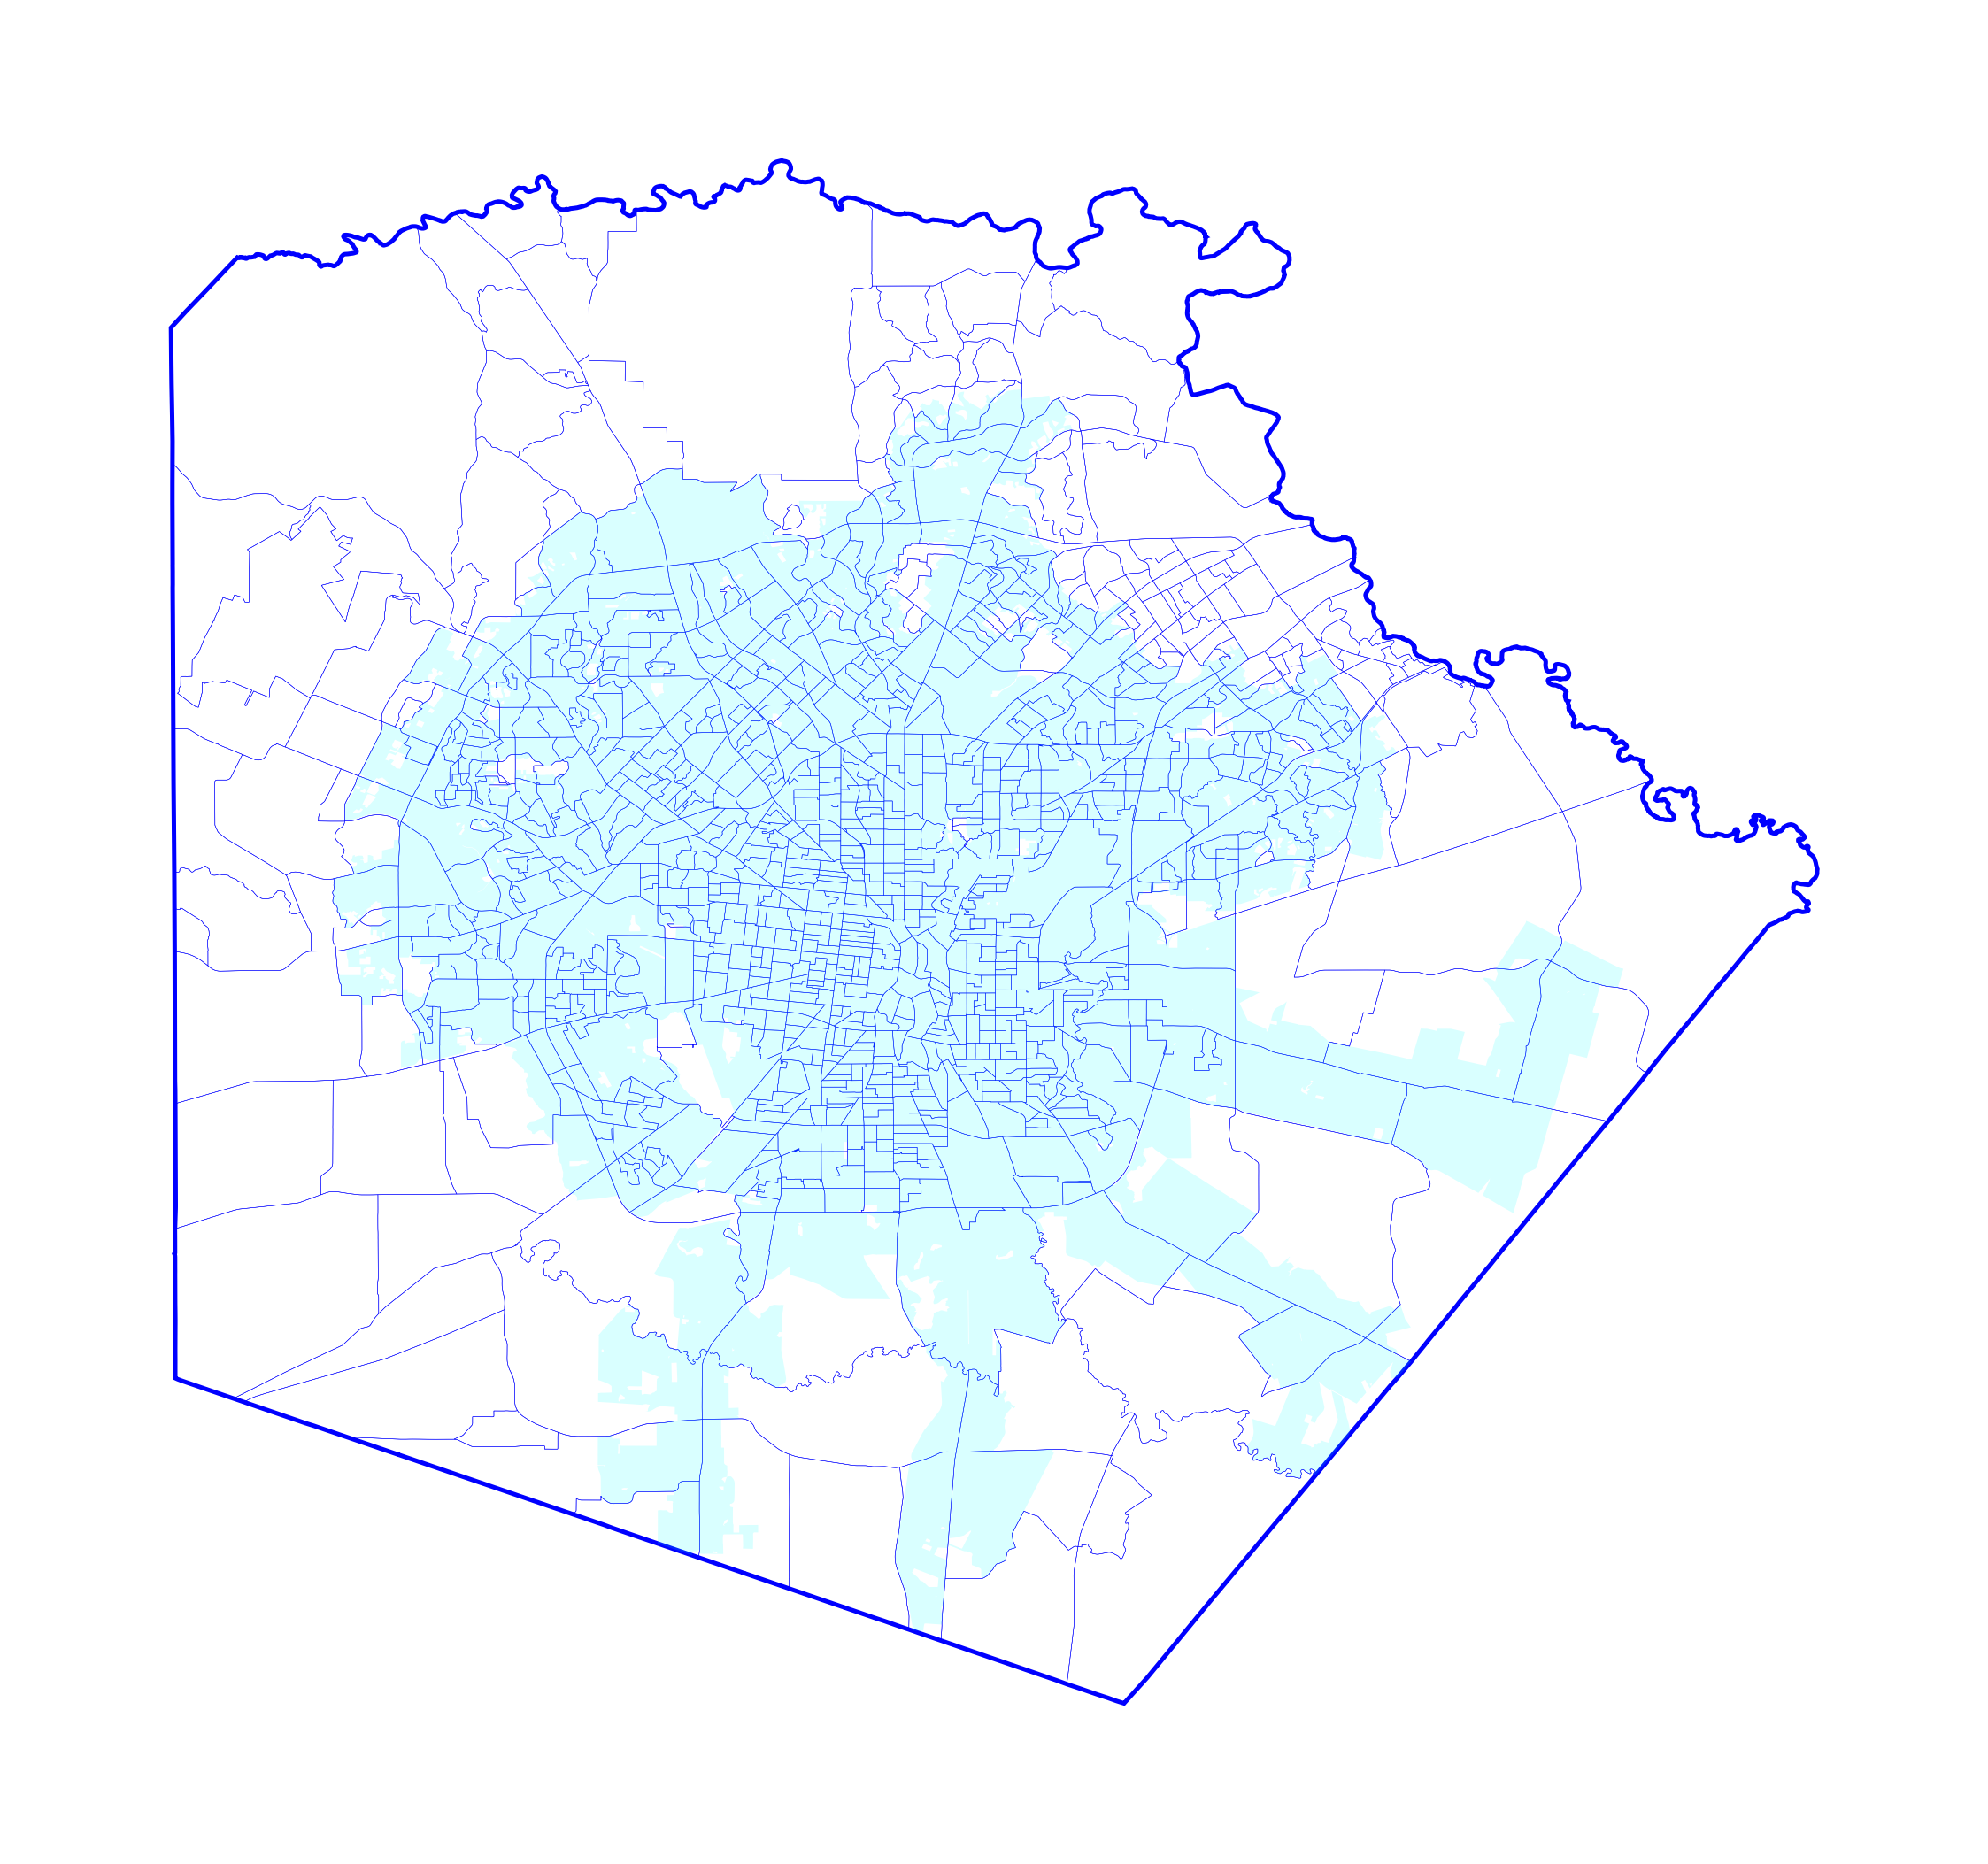

In [120]:
fig, ax = plt.subplots(figsize=(40,40))
ax.set_aspect('equal')
axbase = gplt.polyplot(gdf_counties, ax=ax, facecolor='white', edgecolor='blue', linewidth=5)
gplt.polyplot(gdf_groups, ax=ax, facecolor='None', edgecolor='blue', linewidth=.5)
# gdf_counties.plot()
gdf_groups_stops.plot(ax=ax, edgecolor='None', facecolor='cyan', alpha=.15)

In [100]:
group_stops = pd.DataFrame(gdf_stops_fips.BLOCKGROUP.value_counts()).rename(columns={'BLOCKGROUP':'stop_count'})
print(group_stops.info())
group_stops.head()

<class 'pandas.core.frame.DataFrame'>
Index: 968 entries, 480291101001 to 480291820021
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   stop_count  968 non-null    Int64
dtypes: Int64(1)
memory usage: 16.1+ KB
None


stop_count
480291101001       10017
480291101003        6245
480291101002        5532
480291921001        4078
480291107001        3933

In [65]:
stop_blocks = gdf_stops_blocks.stop_id.value_counts()
len(stop_blocks)

6894

In [66]:
gdf_stops_blocks[['BLOCK','geometry']].head()

BLOCK                                           geometry
10013  480291909021000  POLYGON ((-98.49159 29.51970, -98.49162 29.519...
10019  480291909021000  POLYGON ((-98.49131 29.51958, -98.49135 29.518...
10029  480291909021000  POLYGON ((-98.49148 29.51945, -98.49151 29.518...
10043  480291909021000  POLYGON ((-98.49145 29.51976, -98.49148 29.519...
10059  480291909021000  POLYGON ((-98.49155 29.51936, -98.49158 29.518...

In [67]:
#######################################
###
### via datathon 2020
###
### on time performance
###
#######################################

In [68]:
df_otp = pd.read_csv(files['bus_otp_2020'])
df_otp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107319 entries, 0 to 107318
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ServiceDateTime   107319 non-null  object 
 1   Route             107319 non-null  int64  
 2   RouteName         107319 non-null  object 
 3   EarlyDeparture    107319 non-null  int64  
 4   OnTime            107319 non-null  int64  
 5   LateArrival       107319 non-null  int64  
 6   Missing           107319 non-null  int64  
 7   TimePointCount    107319 non-null  int64  
 8   OTP               107156 non-null  float64
 9   AverageDwellTime  107155 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 8.2+ MB


In [69]:
df_otp.columns

Index(['ServiceDateTime', 'Route', 'RouteName', 'EarlyDeparture', 'OnTime',
       'LateArrival', 'Missing', 'TimePointCount', 'OTP', 'AverageDwellTime'],
      dtype='object')

In [70]:
df_otp.head()

ServiceDateTime  Route           RouteName  EarlyDeparture  OnTime  \
0         2/12/18      2              BLANCO              83     626   
1         2/12/18      3      SAN PEDRO SKIP               5     518   
2         2/12/18      4  SAN PEDRO Frequent              21     454   
3         2/12/18      5          McCULLOUGH               7     403   
4         2/12/18      6      US-281 Express               1      54   

   LateArrival  Missing  TimePointCount    OTP  AverageDwellTime  
0           87       82             796  78.64            103.97  
1           78       11             601  86.19            167.29  
2          109      130             584  77.74             78.31  
3           30       10             440  91.59            211.44  
4           22       11              77  70.13            163.19

In [71]:
#######################################
###
### via datathon 2020
###
### fare box activity
###
#######################################

In [72]:
df_fare = pd.read_csv(files['bus_fare_box_2020'], index_col=0)
df_fare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89623 entries, 0 to 89622
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ServiceDateTime      89623 non-null  object 
 1   Route                89623 non-null  int64  
 2   RouteName            87728 non-null  object 
 3   CurrentRevenue       89623 non-null  float64
 4   Ridership            89623 non-null  int64  
 5   TokenCount           89623 non-null  int64  
 6   TicketCount          89623 non-null  int64  
 7   PassCount            89623 non-null  int64  
 8   BillCount            89623 non-null  int64  
 9   UnclassifiedRevenue  89623 non-null  float64
 10  DumpCount            89623 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 8.2+ MB


In [73]:
df_fare.columns

Index(['ServiceDateTime', 'Route', 'RouteName', 'CurrentRevenue', 'Ridership',
       'TokenCount', 'TicketCount', 'PassCount', 'BillCount',
       'UnclassifiedRevenue', 'DumpCount'],
      dtype='object')

In [74]:
df_fare.head()

ServiceDateTime  Route      RouteName  CurrentRevenue  Ridership  \
0      2017-01-01      2   2-BLANCO RD.          510.82       1244   
1      2017-01-01      3    3-SAN PEDRO          203.93        689   
2      2017-01-01      4    4-SAN PEDRO          356.58       1377   
3      2017-01-01      5  5-MC CULLOUGH          224.80        474   
4      2017-01-01      8   8-N.ST.MARYS          252.29        471   

   TokenCount  TicketCount  PassCount  BillCount  UnclassifiedRevenue  \
0           0            0        588        312                20.88   
1           0            0        371        119                 9.55   
2           0            0        671        230                20.44   
3           0            0        239        124                19.50   
4           0            0        214        147                 6.45   

   DumpCount  
0        116  
1         49  
2         94  
3         64  
4         53

In [75]:
#######################################
###
### via datathon 2020
###
### message logs
###
#######################################

In [76]:
df_logs = pd.read_csv(files['message_logs_2020'])
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155517 entries, 0 to 155516
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dDate              155517 non-null  object 
 1   Local_Timestamp    155517 non-null  object 
 2   Latitude           155517 non-null  float64
 3   Longitude          155517 non-null  float64
 4   MESSAGE_TYPE_TEXT  155517 non-null  object 
 5   ADHERENCE          155517 non-null  int64  
 6   Odometer           155517 non-null  float64
 7   VehicleNumber      155517 non-null  object 
 8   degLat             0 non-null       float64
 9   degLong            0 non-null       float64
dtypes: float64(5), int64(1), object(4)
memory usage: 11.9+ MB


In [77]:
df_logs.columns

Index(['dDate', 'Local_Timestamp', 'Latitude', 'Longitude',
       'MESSAGE_TYPE_TEXT', 'ADHERENCE', 'Odometer', 'VehicleNumber', 'degLat',
       'degLong'],
      dtype='object')

In [78]:
df_logs.head(5)


dDate  Local_Timestamp  Latitude  Longitude MESSAGE_TYPE_TEXT  \
0  2/14/2020  2/14/20 6:56 AM  29.44451  -98.50143  vehicle location   
1  2/14/2020  2/14/20 6:56 AM  29.44452  -98.50142  vehicle location   
2  2/14/2020  2/14/20 6:57 AM  29.44452  -98.50142  vehicle location   
3  2/14/2020  2/14/20 6:57 AM  29.44452  -98.50142  vehicle location   
4  2/14/2020  2/14/20 6:58 AM  29.44452  -98.50142  vehicle location   

   ADHERENCE  Odometer VehicleNumber  degLat  degLong  
0          0       0.0           102     NaN      NaN  
1          0       0.0           102     NaN      NaN  
2          0       0.0           102     NaN      NaN  
3          0       0.0           102     NaN      NaN  
4          0       0.0           102     NaN      NaN

In [79]:
df_logs.MESSAGE_TYPE_TEXT.value_counts()

vehicle location     155152
Return to Network       365
Name: MESSAGE_TYPE_TEXT, dtype: int64

In [80]:
df_logs.ADHERENCE.value_counts().describe()

count       82.000000
mean      1896.548780
std       9608.117182
min          1.000000
25%         16.000000
50%         59.500000
75%        269.250000
max      85096.000000
Name: ADHERENCE, dtype: float64

In [81]:
vehicle_ids = df_logs.VehicleNumber.value_counts()
print(len(vehicle_ids))
vehicle_ids.head(20)

704


PD-29     1324
717        859
PD-22      689
PD-23      626
T-189      602
T-188      566
T-116      511
T-151      476
T-132      460
491        440
C-117      406
T-100      405
T-166      394
982        390
T-195      385
T-120      382
952        371
970        371
953        355
M-2121     351
Name: VehicleNumber, dtype: int64

In [82]:
df_logs[df_logs.VehicleNumber==450].head(20)

dDate  Local_Timestamp  Latitude  Longitude MESSAGE_TYPE_TEXT  \
28851  2/14/2020  2/14/20 6:00 AM  29.45275  -98.51462  vehicle location   
28852  2/14/2020  2/14/20 6:00 AM  29.45083  -98.51278  vehicle location   
28853  2/14/2020  2/14/20 6:01 AM  29.44892  -98.51093  vehicle location   
28854  2/14/2020  2/14/20 6:02 AM  29.44463  -98.50669  vehicle location   
28855  2/14/2020  2/14/20 6:03 AM  29.44217  -98.50430  vehicle location   
28856  2/14/2020  2/14/20 6:04 AM  29.44123  -98.50230  vehicle location   
28857  2/14/2020  2/14/20 6:05 AM  29.43960  -98.49864  vehicle location   
28858  2/14/2020  2/14/20 6:06 AM  29.43702  -98.49696  vehicle location   
28859  2/14/2020  2/14/20 6:06 AM  29.43506  -98.49544  vehicle location   
28860  2/14/2020  2/14/20 6:07 AM  29.43287  -98.49320  vehicle location   
28861  2/14/2020  2/14/20 6:08 AM  29.43244  -98.49192  vehicle location   
28862  2/14/2020  2/14/20 6:08 AM  29.43164  -98.49107  vehicle location   
28863  2/14/2020  2/14/20 6:10 AM  29.42951  -98.49138  vehicle location   
28864  2/14/2020  2/14/20 6:10 AM  29.42873  -98.49140  vehicle location   
28865  2/14/2020  2/14/20 6:11 AM  29.42870  -98.49143  vehicle location   
28866  2/14/2020  2/14/20 6:11 AM  29.42767  -98.49132  vehicle location   
28867  2/14/2020  2/14/20 6:12 AM  29.42641  -98.49131  vehicle location   
28868  2/14/2020  2/14/20 6:12 AM  29.42468  -98.49133  vehicle location   
28869  2/14/2020  2/14/20 6:13 AM  29.42463  -98.49148  vehicle location   
28870  2/14/2020  2/14/20 6:14 AM  29.42398  -98.49177  vehicle location   

       ADHERENCE  Odometer VehicleNumber  degLat  degLong  
28851         -1     24.28           450     NaN      NaN  
28852         -1     24.45           450     NaN      NaN  
28853         -1     24.63           450     NaN      NaN  
28854         -1     25.01           450     NaN      NaN  
28855         -1     25.23           450     NaN      NaN  
28856         -1     25.37           450     NaN      NaN  
28857         -1     25.66           450     NaN      NaN  
28858         -1     25.86           450     NaN      NaN  
28859          0     26.03           450     NaN      NaN  
28860          0     26.23           450     NaN      NaN  
28861          0     26.31           450     NaN      NaN  
28862          0     26.38           450     NaN      NaN  
28863          0     26.54           450     NaN      NaN  
28864         -1     26.59           450     NaN      NaN  
28865         -1     26.59           450     NaN      NaN  
28866         -1     26.66           450     NaN      NaN  
28867         -1     26.75           450     NaN      NaN  
28868         -1     26.87           450     NaN      NaN  
28869         -2     26.88           450     NaN      NaN  
28870         -2     26.93           450     NaN      NaN

In [83]:
#######################################
###
### via datathon 2020
###
### service miles
###
#######################################

In [84]:
df_svc_miles = pd.read_csv(files['service_miles_2020'])
df_svc_miles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63622 entries, 0 to 63621
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Route                63622 non-null  int64  
 1   RouteName            63622 non-null  object 
 2   Class                62115 non-null  object 
 3   ServiceType          63622 non-null  object 
 4   ScheduledMiles       63622 non-null  float64
 5   AVLRevenueMiles      63622 non-null  float64
 6   AVLDeadHeadMiles     63622 non-null  float64
 7   AVLExemptMiles       63622 non-null  float64
 8   AVLMilesAdjustments  63622 non-null  float64
 9   ServiceDate          63622 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 4.9+ MB


In [85]:
df_svc_miles.columns


Index(['Route', 'RouteName', 'Class', 'ServiceType', 'ScheduledMiles',
       'AVLRevenueMiles', 'AVLDeadHeadMiles', 'AVLExemptMiles',
       'AVLMilesAdjustments', 'ServiceDate'],
      dtype='object')

In [86]:
df_svc_miles.head()

Route         RouteName          Class ServiceType  ScheduledMiles  \
0      2      2-BLANCO RD.   Major Radial      SUNDAY          924.35   
1      3  3-SAN PEDRO SKIP  Major Limited      SUNDAY          707.88   
2      4       4-SAN PEDRO   Major Radial      SUNDAY          731.48   
3      5     5-MC CULLOUGH   Major Radial      SUNDAY          484.17   
4      6  6-US 281 Express  Major Express      SUNDAY            0.00   

   AVLRevenueMiles  AVLDeadHeadMiles  AVLExemptMiles  AVLMilesAdjustments  \
0           886.97             46.91             0.0                 26.0   
1           683.66             19.57             0.0                  0.0   
2           692.08             34.76             0.0                  0.0   
3           457.37             22.12             0.0                  0.0   
4             0.00              0.00             0.0                  0.0   

  ServiceDate  
0    1/1/2019  
1    1/1/2019  
2    1/1/2019  
3    1/1/2019  
4    1/1/2019

In [87]:
#######################################
###
### via datathon 2020
###
### stop addresses
###
#######################################

In [88]:
df_stop_addrs = pd.read_csv(files['stops_addr_2020'])
df_stop_addrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9859 entries, 0 to 9858
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   StopNumber    9859 non-null   object 
 1   Location      9859 non-null   object 
 2   StreetNumber  9715 non-null   float64
 3   Street        9854 non-null   object 
 4   City          9854 non-null   object 
 5   State         9854 non-null   object 
 6   Zip           9854 non-null   float64
dtypes: float64(2), object(5)
memory usage: 539.3+ KB


In [89]:
df_stop_addrs.columns

Index(['StopNumber', 'Location', 'StreetNumber', 'Street', 'City', 'State',
       'Zip'],
      dtype='object')

In [90]:
df_stop_addrs.head()

StopNumber                             Location  StreetNumber  \
0      79877    ST. MARY'S BETWEEN CONVENT & MART         603.0   
1      79977                   ST. MARY'S & PECAN         152.0   
2      89377  ST. MARY'S BETWEEN TRAVIS & HOUSTON         175.0   
3      89867                ST. MARY'S & COMMERCE         106.0   
4      89839                   COMMERCE & SOLEDAD         102.0   

           Street         City State      Zip  
0  N St Mary's St  San Antonio    TX  78205.0  
1      E Pecan St  San Antonio    TX  78205.0  
2    E Houston St  San Antonio    TX  78205.0  
3  S St Mary's St  San Antonio    TX  78205.0  
4        Main Plz  San Antonio    TX  78205.0